Top 10 Features Correlated with Readmission:
target                      1.000000
number_inpatient            0.143847
time_in_hospital            0.125746
num_medications             0.104603
num_procedures              0.098195
age                         0.069389
admission_type_id           0.044181
number_emergency            0.010829
number_diagnoses            0.003163
discharge_disposition_id   -0.009368
Name: target, dtype: float64

Balanced Model Performance Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        51
           1       0.00      0.00      0.00         7

    accuracy                           0.88        58
   macro avg       0.44      0.50      0.47        58
weighted avg       0.77      0.88      0.82        58



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Local\Temp\ipykernel

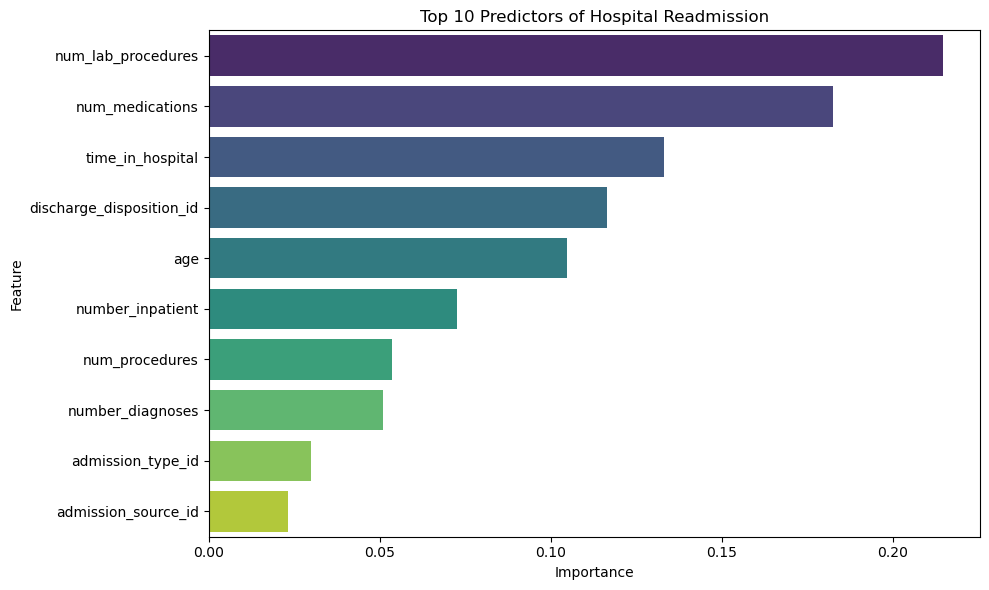

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# --- 1. DATA ACQUISITION ---
file_path = r"C:\Users\hp\Desktop\DataSets\diabetes+130-us+hospitals+for+years+1999-2008\diabetic_data.csv"
df = pd.read_csv(file_path)

# --- 2. DATA PREPROCESSING & CLEANING ---
# Handle missing values
df.replace('?', np.nan, inplace=True)
cols_to_drop = ['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr']
df.drop(columns=cols_to_drop, inplace=True)
df.dropna(inplace=True)

# Create binary target (Readmitted < 30 days)
df['target'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df.drop(columns=['readmitted'], inplace=True)

# Map Age to numerical midpoints
age_dict = {'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35, '[40-50)':45, 
            '[50-60)':55, '[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95}
df['age'] = df['age'].map(age_dict)

# Function to categorize complex ICD-9 codes
def categorize_icd9(code):
    if pd.isnull(code): return 'Other'
    code = str(code)
    if code.startswith(('V', 'E')): return 'Other'
    try:
        val = float(code)
        if 390 <= val <= 459 or val == 785: return 'Circulatory'
        elif 460 <= val <= 519 or val == 786: return 'Respiratory'
        elif 520 <= val <= 579 or val == 787: return 'Digestive'
        elif 250 <= val < 251: return 'Diabetes'
        elif 800 <= val <= 999: return 'Injury'
        elif 710 <= val <= 739: return 'Musculoskeletal'
        elif 580 <= val <= 629 or val == 788: return 'Genitourinary'
        elif 140 <= val <= 239: return 'Neoplasms'
        else: return 'Other'
    except ValueError: return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].apply(categorize_icd9)

# One-Hot Encoding for all categorical variables
categorical_cols = ['race', 'gender', 'change', 'diabetesMed', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Ensure only numeric data remains
df = df.select_dtypes(include=[np.number])

# --- 3. EXPLORATORY DATA ANALYSIS (EDA) ---
# Print top correlations to understand key drivers
print("Top 10 Features Correlated with Readmission:")
print(df.corr()['target'].sort_values(ascending=False).head(10))

# --- 4. PREDICTIVE MODELING ---
X = df.drop('target', axis=1)
y = df['target']

# Stratified split to maintain class balance in test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Balanced Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# --- 5. EVALUATION & VISUALIZATION ---
predictions = model.predict(X_test)
print("\nBalanced Model Performance Report:")
print(classification_report(y_test, predictions))

# Visualize Feature Importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Top 10 Predictors of Hospital Readmission')
plt.tight_layout()
plt.show()